In [31]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.utils.dataset_creator import *
from files.neural_networks.base_class import *
import torch.nn as nn
import os

(None, (300, 2))

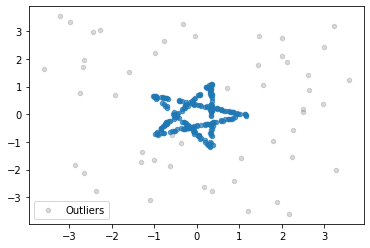

In [32]:
base_path = joinpath("..", "..", "datasets", "2d", "lines")

content = None
with open(joinpath(base_path, "star5.csv")) as f:
    content = f.read().split("\n")
    content = np.array([[float(s) for s in c.split(",")] for c in content if c != ""]).astype(float).T
with open(joinpath(base_path, "star5_gt.csv")) as f:
    gt = np.array([int(s)  for l in f.read().split("\n") for s in l if l != ""])
    gt[gt > 1] = 1

of = 0.2
outliers = np.random.uniform(-3, 3, size=(int(len(content)*of), 2))
gt = np.append(gt, [0 for _ in outliers])
ds = np.vstack((content, outliers))


# ds, gt = create_dataset_parabola(500, a_s=[1, -1], centers=[(2, 2), (-2, -2)], rot_angle=[0, 90], outliers_fraction=0.2)

ds = normalize_points(ds)

idxs = np.arange(len(ds))
np.random.shuffle(idxs)
ds = ds[idxs]
gt = gt[idxs]

plot(ds[gt == 0], c='gray', alpha=0.3, label="Outliers")
plot(ds[gt != 0]), ds.shape

In [33]:
from files.NeuralRansac import *

sac = NeuralRansac(data=ds, model_name=SOM, v=NEW_INLIERS, in_th=20)#, in_th=[0.5, 1, 0.75])
scores = sac.anomaly_detection(epochs=100, k_max=50, mss=10)

--------------------------------------------------
Building RanSac models
Iteration 7/50: [====>..........................] (14%) ETA: 0:00:00.480163 Len best cons: 75

/opt/anaconda3/envs/torch/lib/python3.8/site-packages/minisom.py:160: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Iteration 50/50: [==============================] (100%) ETA: 0:00:03.190263 Len best cons: 755
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


In [34]:
if False:
    for i, (model, (cons, mss, ithr)) in enumerate(sac.models.items()):
        # if i > 10: break
        if sac.model_name == SOM: model.plot_weights_lattice(ds, title=f"Model {i} ithr: {ithr}")
        else: 
            plot(ds, title=f"Model {i} ithr: {ithr}", new_fig=True, dpi=100, c='gray', alpha=0.3)
            # plot(model.predict(ds), label="PREDS")
        plot(mss, label="MSS")
        plot(cons, label="CONS")

<AxesSubplot:>

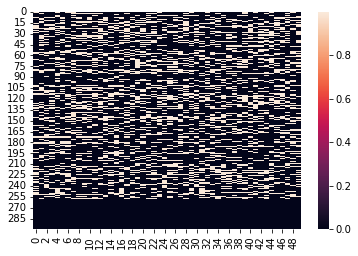

In [35]:
import seaborn as sns

sns.heatmap(sac.preference_matrix)

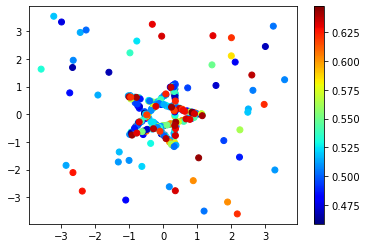

In [36]:
plt.scatter(ds[:,0], ds[:,1], c=scores, cmap="jet")
plt.colorbar()

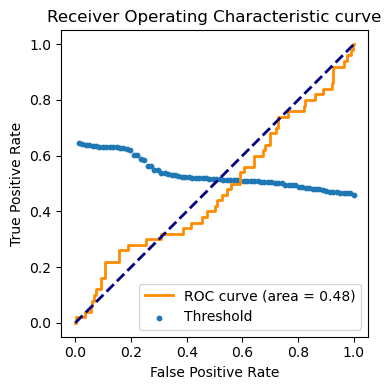

In [37]:
from sklearn.metrics import roc_curve, auc
# scores_norm = softmax(scores_old)
gt[gt > 1] = 1
fpr, tpr, thr = roc_curve(1-gt, scores)
roc_auc: float = auc(fpr, tpr)

lw = 2
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.axis('equal')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic curve')
plt.tight_layout()

stop = 0
plt.scatter(np.linspace(0, 1, len(thr)-stop), thr[stop:], s=10, label="Threshold")
plt.legend(loc="lower right")